In [1]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import sys

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

import joblib

import netCDF4
from netCDF4 import Dataset as ncFile
import datetime as dt
from dypy.small_tools import interpolate
from dypy.lagranto import Tra
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.gridspec import GridSpec
from dypy.plotting import plot_trajs
from collections import Counter
import pandas as pd
from glob import glob 


import matplotlib.gridspec as gridspec

In [2]:
### Inspect the data

path = '/net/helium/atmosdyn/freimax/data_msc/casestudy_ra/data/cdf'

# with open(f'{path}/traj.txt', 'r') as file:
#     lines = file.readlines()
# for i, line in enumerate(lines):
#     print(f'Line {i+1}: {line}')
#     if i > 6:  # Let's not print too much; adjust as needed
#         break


In [3]:
## Read tra-file with pandas
df_traj = pd.read_csv(f'{path}/traj.txt', delim_whitespace=True, skiprows=[0, 1, 3, 4])
df_traj

,time,lon,lat,p,PS,Q,T,SWC,IWC,RWC,tsubi,tsubs,tmelts,tmelti,tevr,CC,OMEGA
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.001,0.000,0.010,0.000,-0.015,-0.425,0.0,0.0,0.000,-0.053
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.013,0.000,0.007,0.000,-0.059,-0.522,0.0,0.0,0.000,-0.027
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.026,0.000,0.006,0.000,-0.116,-0.553,0.0,0.0,0.000,-0.012
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.026,0.000,0.005,0.000,-0.106,-0.520,0.0,0.0,0.000,0.008
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.058,0.000,0.003,0.000,-0.176,-0.397,0.0,0.0,0.000,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102258,-44.0,160.84,47.74,864,1008.900,0.001,-7.174,0.001,0.007,0.000,-0.020,0.000,0.000,0.0,0.0,0.209,0.202
102259,-45.0,160.34,47.87,857,1009.701,0.001,-7.303,0.000,0.000,0.000,-0.005,0.000,0.000,0.0,0.0,0.035,0.197
102260,-46.0,159.82,48.02,851,1009.092,0.001,-7.593,0.000,0.002,0.000,-0.007,0.000,0.000,0.0,0.0,0.074,0.116
102261,-47.0,159.30,48.18,848,1009.588,0.001,-7.453,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.007,0.013


In [4]:
df_traj['id'] = np.zeros(df_traj.shape[0])
df_traj['tmeltsi'] = df_traj['tmelts'] + df_traj['tmelti']
df_traj['tsubsi'] = df_traj['tsubs'] + df_traj['tsubi']
df_traj['SIWC'] = df_traj['SWC'] + df_traj['IWC']
df_traj = df_traj.drop(columns=['tmelts', 'tmelti', 'tsubs', 'tsubi', 'SWC', 'IWC'])
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.010,0.0,0.000,-0.053,0.0,-0.425,-0.015,0.001
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.007,0.0,0.000,-0.027,0.0,-0.522,-0.059,0.013
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.006,0.0,0.000,-0.012,0.0,-0.553,-0.116,0.026
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.005,0.0,0.000,0.008,0.0,-0.520,-0.106,0.026
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.003,0.0,0.000,-0.001,0.0,-0.397,-0.176,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102258,-44.0,160.84,47.74,864,1008.900,0.001,-7.174,0.000,0.0,0.209,0.202,0.0,0.000,-0.020,0.008
102259,-45.0,160.34,47.87,857,1009.701,0.001,-7.303,0.000,0.0,0.035,0.197,0.0,0.000,-0.005,0.000
102260,-46.0,159.82,48.02,851,1009.092,0.001,-7.593,0.000,0.0,0.074,0.116,0.0,0.000,-0.007,0.002
102261,-47.0,159.30,48.18,848,1009.588,0.001,-7.453,0.000,0.0,0.007,0.013,0.0,0.000,0.000,0.000


In [5]:
df_traj.describe()

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
count,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.000000,102263.0,102263.000000,102263.000000,102263.000000
mean,-24.000000,119.024158,13.615525,872.505373,930.098508,-32.853341,-35.077277,-32.854386,-32.857560,-32.708467,-32.900423,0.0,-65.726192,-65.794526,-65.667864
std,14.142205,209.724995,186.680873,352.907942,355.968574,178.260399,177.903150,178.260207,178.259622,178.287303,178.251830,0.0,356.517209,356.504630,356.527963
min,-48.000000,-999.000000,-999.000000,-999.000000,-999.990000,-999.990000,-999.990000,-999.990000,-999.990000,-999.990000,-999.990000,0.0,-1999.980000,-1999.980000,-1999.980000
25%,-36.000000,157.840000,45.480000,908.000000,985.195000,0.002000,-4.673000,0.000000,0.000000,0.000000,-0.085000,0.0,0.000000,-0.126000,0.000000
50%,-24.000000,162.140000,47.080000,961.000000,999.326000,0.003000,-1.319000,0.000000,0.000000,0.000000,-0.012000,0.0,0.000000,-0.031000,0.005000
75%,-12.000000,165.820000,48.900000,986.000000,1004.884000,0.003000,0.484000,0.000000,0.000000,0.159000,0.030000,0.0,0.000000,-0.005000,0.045000
max,0.000000,180.000000,63.950000,1019.000000,1021.493000,0.009000,15.691000,0.324000,0.002000,1.000000,1.942000,0.0,0.002000,0.001000,0.625000


In [6]:
print(f'Weird tmeltsi values:\t{[df_traj["tmeltsi"]< -100][0].sum()}')
print(f'Weird tsubsi values:\t{[df_traj["tsubsi"]< -100][0].sum()}')
print(f'Weird tevr values:\t{[df_traj["tevr"]< -100][0].sum()}')



Weird tmeltsi values:	3360
Weird tsubsi values:	3360
Weird tevr values:	3360


In [7]:
## Add a labels column
id_counter = 0
for idx, time in enumerate(df_traj.loc[:]['time']):
    ## ID is always the floored devison of 48 against time
    if time == 0.:
        id_counter += 1
    
    df_traj.loc[idx, 'id'] = id_counter


In [8]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.010,0.0,0.000,-0.053,1.0,-0.425,-0.015,0.001
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.007,0.0,0.000,-0.027,1.0,-0.522,-0.059,0.013
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.006,0.0,0.000,-0.012,1.0,-0.553,-0.116,0.026
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.005,0.0,0.000,0.008,1.0,-0.520,-0.106,0.026
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.003,0.0,0.000,-0.001,1.0,-0.397,-0.176,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102258,-44.0,160.84,47.74,864,1008.900,0.001,-7.174,0.000,0.0,0.209,0.202,2087.0,0.000,-0.020,0.008
102259,-45.0,160.34,47.87,857,1009.701,0.001,-7.303,0.000,0.0,0.035,0.197,2087.0,0.000,-0.005,0.000
102260,-46.0,159.82,48.02,851,1009.092,0.001,-7.593,0.000,0.0,0.074,0.116,2087.0,0.000,-0.007,0.002
102261,-47.0,159.30,48.18,848,1009.588,0.001,-7.453,0.000,0.0,0.007,0.013,2087.0,0.000,0.000,0.000


---
#### Inspect the values with cooling < -1000

In [9]:
df_weird = df_traj[(df_traj['tmeltsi'] < -100) & (df_traj["tsubsi"] < -100) & (df_traj["tevr"] < -100)]
df_weird

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
2108,-1.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,44.0,-1999.98,-1999.98,-1999.98
2109,-2.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,44.0,-1999.98,-1999.98,-1999.98
2110,-3.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,44.0,-1999.98,-1999.98,-1999.98
2111,-4.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,44.0,-1999.98,-1999.98,-1999.98
2112,-5.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,44.0,-1999.98,-1999.98,-1999.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,-44.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,2000.0,-1999.98,-1999.98,-1999.98
97996,-45.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,2000.0,-1999.98,-1999.98,-1999.98
97997,-46.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,2000.0,-1999.98,-1999.98,-1999.98
97998,-47.0,-999.0,-999.0,-999,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,2000.0,-1999.98,-1999.98,-1999.98


In [10]:
weird_ids = np.unique(df_weird.id)

weird_lons = df_traj.lon[df_traj.id.isin(weird_ids) & (df_traj.time==0)]
weird_lats = df_traj.lat[df_traj.id.isin(weird_ids) & (df_traj.time==0)]


In [11]:
weird_ids.shape[0] *48

3360

---
### Analyze trajectories with instantaneous and accumulated versions

In [12]:
## Drop weird values
df_traj = df_traj[(df_traj['tmeltsi'] > -100) & (df_traj["tsubsi"] > -100) & (df_traj["tevr"] > -100)]
df_traj.reset_index(drop=True, inplace=True)


In [13]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.010,0.0,0.000,-0.053,1.0,-0.425,-0.015,0.001
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.007,0.0,0.000,-0.027,1.0,-0.522,-0.059,0.013
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.006,0.0,0.000,-0.012,1.0,-0.553,-0.116,0.026
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.005,0.0,0.000,0.008,1.0,-0.520,-0.106,0.026
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.003,0.0,0.000,-0.001,1.0,-0.397,-0.176,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98898,-44.0,160.84,47.74,864,1008.900,0.001,-7.174,0.000,0.0,0.209,0.202,2087.0,0.000,-0.020,0.008
98899,-45.0,160.34,47.87,857,1009.701,0.001,-7.303,0.000,0.0,0.035,0.197,2087.0,0.000,-0.005,0.000
98900,-46.0,159.82,48.02,851,1009.092,0.001,-7.593,0.000,0.0,0.074,0.116,2087.0,0.000,-0.007,0.002
98901,-47.0,159.30,48.18,848,1009.588,0.001,-7.453,0.000,0.0,0.007,0.013,2087.0,0.000,0.000,0.000


In [14]:
bcp_mean = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].mean().reset_index()
bcp_median = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].median().reset_index()

bcp_q25 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.25).reset_index()
bcp_q75 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.75).reset_index()

bcp_q10 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.10).reset_index()
bcp_q90 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.90).reset_index()

bcp_q1 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.01).reset_index()
bcp_q99 = df_traj.groupby(['time'])[['tsubsi', 'tmeltsi', 'tevr']].quantile(0.99).reset_index()


Text(0.5, 1.0, 'tevr')

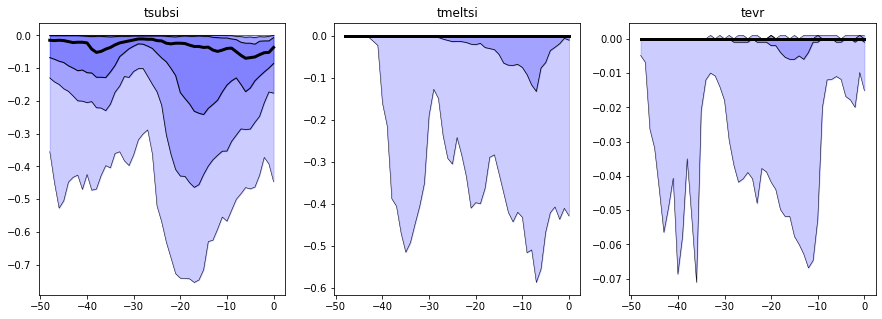

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,5), )

ax[0].plot(bcp_q1['time']    , bcp_q1['tsubsi']    , c='k' , linewidth=0.5)
ax[0].plot(bcp_q99['time']   , bcp_q99['tsubsi']   , c='k' , linewidth=0.5)
ax[0].plot(bcp_q10['time']   , bcp_q10['tsubsi']   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q90['time']   , bcp_q90['tsubsi']   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q25['time']   , bcp_q25['tsubsi']   , c='k' , linewidth=1)
ax[0].plot(bcp_q75['time']   , bcp_q75['tsubsi']   , c='k' , linewidth=1)
ax[0].plot(bcp_median['time'], bcp_median['tsubsi'], c='k' , linewidth=3)

ax[0].fill_between(bcp_q1['time'] , bcp_q1['tsubsi'] , bcp_q99['tsubsi'], color='blue', alpha=0.2)
ax[0].fill_between(bcp_q10['time'], bcp_q10['tsubsi'], bcp_q90['tsubsi'], color='blue', alpha=0.2)
ax[0].fill_between(bcp_q25['time'], bcp_q25['tsubsi'], bcp_q75['tsubsi'], color='blue', alpha=0.2)

ax[0].set_title('tsubsi')


bc_process = 'tmeltsi'
ax[1].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=0.5)
ax[1].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=0.5)
ax[1].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[1].fill_between(bcp_q1['time'] , bcp_q1[bc_process] , bcp_q99[bc_process], color='blue', alpha=0.2)
ax[1].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[1].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[1].set_title(bc_process)


bc_process = 'tevr'
ax[2].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=0.5)
ax[2].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=0.5)
ax[2].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[2].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[2].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[2].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[2].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[2].fill_between(bcp_q1['time'] , bcp_q1[bc_process] , bcp_q99[bc_process], color='blue', alpha=0.2)
ax[2].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[2].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[2].set_title(bc_process)


In [16]:
# ### THIS IS A TEST HOW OF ACCUMULATE AND SUM --> CUMSUM() FUNCTION

# ## Select a specifc ID
# df_traj_id1 = df_traj[df_traj.id==1]

# ## Accumulate the colings
# t = -49
# acc_tsubsi = np.zeros(df_traj_id1.shape[0])
# acc_cooling = 0
# while t < 0:
#     t += 1
#     acc_cooling += df_traj_id1.tsubsi[df_traj_id1['time']==t].values
#     # print(acc_cooling)
#     acc_tsubsi[-t] = acc_cooling


In [17]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.010,0.0,0.000,-0.053,1.0,-0.425,-0.015,0.001
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.007,0.0,0.000,-0.027,1.0,-0.522,-0.059,0.013
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.006,0.0,0.000,-0.012,1.0,-0.553,-0.116,0.026
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.005,0.0,0.000,0.008,1.0,-0.520,-0.106,0.026
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.003,0.0,0.000,-0.001,1.0,-0.397,-0.176,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98898,-44.0,160.84,47.74,864,1008.900,0.001,-7.174,0.000,0.0,0.209,0.202,2087.0,0.000,-0.020,0.008
98899,-45.0,160.34,47.87,857,1009.701,0.001,-7.303,0.000,0.0,0.035,0.197,2087.0,0.000,-0.005,0.000
98900,-46.0,159.82,48.02,851,1009.092,0.001,-7.593,0.000,0.0,0.074,0.116,2087.0,0.000,-0.007,0.002
98901,-47.0,159.30,48.18,848,1009.588,0.001,-7.453,0.000,0.0,0.007,0.013,2087.0,0.000,0.000,0.000


In [18]:
def accumulate_columns(df):
    df = df.sort_index(ascending=False)
    df['Atsubsi'] = df['tsubsi'].cumsum()
    df['Atmeltsi'] = df['tmeltsi'].cumsum()
    df['Atevr'] = df['tevr'].cumsum()
    return df

# Apply the function to each id-group
df_traj = df_traj.groupby('id').apply(accumulate_columns)
# Reset the Multi-index to a single index
df_traj = df_traj.reset_index('id', drop=True)

In [19]:
df_traj[40:60]

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC,Atsubsi,Atmeltsi,Atevr
8,-8.0,160.63,48.59,981,982.606,0.004,0.767,0.001,0.0,0.0,-0.069,1.0,-0.130,-0.429,0.289,-5.500,-1.341,-0.437
7,-7.0,160.09,48.13,979,979.884,0.004,0.763,0.000,0.0,0.0,-0.068,1.0,-0.138,-0.455,0.265,-5.955,-1.479,-0.437
6,-6.0,159.68,47.59,977,977.842,0.004,0.902,0.001,0.0,0.0,-0.047,1.0,-0.224,-0.454,0.212,-6.409,-1.703,-0.437
5,-5.0,159.52,47.02,976,977.040,0.004,1.015,0.002,0.0,0.0,-0.018,1.0,-0.280,-0.292,0.128,-6.701,-1.983,-0.437
4,-4.0,159.66,46.47,976,977.058,0.004,1.086,0.003,0.0,0.0,-0.001,1.0,-0.397,-0.176,0.058,-6.877,-2.380,-0.437
3,-3.0,160.08,45.99,976,977.107,0.004,1.154,0.005,0.0,0.0,0.008,1.0,-0.520,-0.106,0.026,-6.983,-2.900,-0.437
2,-2.0,160.72,45.60,976,977.409,0.004,1.157,0.006,0.0,0.0,-0.012,1.0,-0.553,-0.116,0.026,-7.099,-3.453,-0.437
1,-1.0,161.51,45.33,975,977.168,0.004,1.305,0.007,0.0,0.0,-0.027,1.0,-0.522,-0.059,0.013,-7.158,-3.975,-0.437
0,0.0,162.40,45.20,974,976.028,0.004,1.758,0.010,0.0,0.0,-0.053,1.0,-0.425,-0.015,0.001,-7.173,-4.400,-0.437
97,-48.0,176.84,59.28,1002,1004.375,0.002,-1.491,0.000,0.0,0.0,-0.013,2.0,0.000,-0.069,0.003,-0.069,0.000,0.000


In [20]:
# df_traj.index = df_traj.index.droplevel('id')
print(df_traj.index)

Int64Index([   48,    47,    46,    45,    44,    43,    42,    41,    40,
               39,
            ...
            98863, 98862, 98861, 98860, 98859, 98858, 98857, 98856, 98855,
            98854],
           dtype='int64', length=98903)


---
#### Make predictions along trajectories using the random forest

In [21]:
## Load models:
model_tmeltsi = joblib.load('/net/helium/atmosdyn/freimax/data_msc/IFS-18/models_rhifs/tmeltsi/full_data_girdsearch_tmeltsi_f1.joblib') 
print('Model 1 loaded')
model_tsubsi = joblib.load('/net/helium/atmosdyn/freimax/data_msc/IFS-18/models_rhifs/tsubsi/first_try_tsubsi.joblib')
print('Model 2 loaded')

Model 1 loaded
Model 2 loaded


In [26]:
## Calculate RH_ifs

def calculate_e_sat(T, phase):
    a1 = 611.21  #Pa
    T0 = 273.16  #K
    # Assign differetn parameter depending on surface of ice or water
    if phase == 'w':
        a3 = 17.502
        a4 = 32.19  #K
    elif phase == 'i':
        a3 = 22.587
        a4 = -0.7 #K
    else:
        raise ValueError("Invalid input: phase must be either 'i' or 'w'")
    ## Calculate the saturation vapor pressure over ice or water
    return a1 * np.exp( a3 * ( (T-T0) / (T-a4) ))


def calculate_e_sat_T(T):
    # Define threhsold values of temperrture
    T_ice = 250.16
    T_0    = 273.16


    # Define the conditions
    cond_liq = T >= T_0
    cond_ice = T <= T_ice
    cond_mix = (T > T_ice) & (T < T_0)
    
    # Calculate intermediate alpha values
    alpha_intermediate = ((T - T_ice) / (T_0 - T_ice))**2
    # Define the values for each condition
    values_liq = np.ones_like(T)
    values_ice = np.zeros_like(T)
    values_mix = np.where(cond_mix, alpha_intermediate, 0)

    # Define Alpha by appling conditions and values using np.select
    alpha = np.select([cond_liq, cond_ice, cond_mix], [values_liq, values_ice, values_mix])
    
    e_sat_w = calculate_e_sat(T=T, phase='w') 
    e_sat_i = calculate_e_sat(T=T, phase='i')
    # Calculate e_sat(T) using the previously computed alpha
    return alpha * e_sat_w + (1-alpha) * e_sat_i
        

def calculate_rh_ifs(row):
    """
    pres:       Pressure field (4d)  -> create using PRES_3d(data_set_PS, like_var4d)

    q:          Specific humidity field (4d)

    T:          Tempoerature fields (4d)
    
    """

    pres = row['p']
    q = row['Q']
    T = row['T']    

    ## Change units
    pres = pres * 100               # Convert hPa to Pa
    T_ndarray = T + 273.16   # Convert temperature to Kelvin

    # Get the Ratio of vapor / dry-air (molar masses)
    epsilon = 0.621981 

    # Calculate the vapor pressure
    vap_pres = pres * q * (1/epsilon) / (1 + q * (1/epsilon-1))
    # Calculate the saturation vapor pressure
    e_sat_T = calculate_e_sat_T(T_ndarray) 

    # Return the ration of vap_pres and sat_vap_pres (=RH)
    return vap_pres / e_sat_T

In [27]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC,Atsubsi,Atmeltsi,Atevr
48,-48.0,176.12,58.71,995,1001.926,0.002,-1.035,0.0,0.0,0.000,-0.017,1.0,0.000,-0.088,0.004,-0.088,0.000,0.000
47,-47.0,175.31,58.69,994,1001.283,0.002,-0.866,0.0,0.0,0.000,-0.033,1.0,0.000,-0.086,0.004,-0.174,0.000,0.000
46,-46.0,174.46,58.64,993,999.892,0.002,-0.824,0.0,0.0,0.000,-0.011,1.0,0.000,-0.094,0.005,-0.268,0.000,0.000
45,-45.0,173.57,58.56,992,999.904,0.002,-0.640,0.0,0.0,0.000,-0.027,1.0,0.000,-0.160,0.009,-0.428,0.000,0.000
44,-44.0,172.66,58.43,992,998.950,0.002,-0.637,0.0,0.0,0.000,-0.017,1.0,0.000,-0.236,0.015,-0.664,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,-4.0,163.23,46.26,744,975.876,0.002,-13.915,0.0,0.0,0.486,-0.318,2087.0,0.001,-0.039,0.051,-5.941,0.001,0.001
98857,-3.0,163.95,46.93,733,975.122,0.001,-14.918,0.0,0.0,0.427,-0.274,2087.0,0.000,-0.033,0.037,-5.974,0.001,0.001
98856,-2.0,164.34,47.56,721,974.103,0.001,-15.773,0.0,0.0,0.452,-0.254,2087.0,0.000,-0.056,0.046,-6.030,0.001,0.001
98855,-1.0,164.47,48.06,714,973.140,0.001,-16.317,0.0,0.0,0.359,-0.133,2087.0,0.000,-0.034,0.047,-6.064,0.001,0.001


In [28]:
# Create a copy of df_traj
df_traj_rf = df_traj[['time', 'lon', 'lat', 'p', 'id', 'RWC', 'T', 'OMEGA', 'SIWC', 'CC']].copy()
# Apply the function to each row
df_traj_rf['RH_ifs'] = df_traj.apply(calculate_rh_ifs, axis=1)

In [29]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC,Atsubsi,Atmeltsi,Atevr
48,-48.0,176.12,58.71,995,1001.926,0.002,-1.035,0.0,0.0,0.000,-0.017,1.0,0.000,-0.088,0.004,-0.088,0.000,0.000
47,-47.0,175.31,58.69,994,1001.283,0.002,-0.866,0.0,0.0,0.000,-0.033,1.0,0.000,-0.086,0.004,-0.174,0.000,0.000
46,-46.0,174.46,58.64,993,999.892,0.002,-0.824,0.0,0.0,0.000,-0.011,1.0,0.000,-0.094,0.005,-0.268,0.000,0.000
45,-45.0,173.57,58.56,992,999.904,0.002,-0.640,0.0,0.0,0.000,-0.027,1.0,0.000,-0.160,0.009,-0.428,0.000,0.000
44,-44.0,172.66,58.43,992,998.950,0.002,-0.637,0.0,0.0,0.000,-0.017,1.0,0.000,-0.236,0.015,-0.664,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,-4.0,163.23,46.26,744,975.876,0.002,-13.915,0.0,0.0,0.486,-0.318,2087.0,0.001,-0.039,0.051,-5.941,0.001,0.001
98857,-3.0,163.95,46.93,733,975.122,0.001,-14.918,0.0,0.0,0.427,-0.274,2087.0,0.000,-0.033,0.037,-5.974,0.001,0.001
98856,-2.0,164.34,47.56,721,974.103,0.001,-15.773,0.0,0.0,0.452,-0.254,2087.0,0.000,-0.056,0.046,-6.030,0.001,0.001
98855,-1.0,164.47,48.06,714,973.140,0.001,-16.317,0.0,0.0,0.359,-0.133,2087.0,0.000,-0.034,0.047,-6.064,0.001,0.001


In [30]:
## Exclude domain filtered values (SIWC=0, T=0)
df_traj_rf_tsubsi_filtered = df_traj_rf[df_traj_rf.SIWC > 0]
df_traj_rf_tmeltsi_filtered = df_traj_rf[(df_traj_rf.SIWC > 0) & (df_traj_rf['T'] > 0)]

In [31]:
df_traj

,time,lon,lat,p,PS,Q,T,RWC,tevr,CC,OMEGA,id,tmeltsi,tsubsi,SIWC,Atsubsi,Atmeltsi,Atevr
48,-48.0,176.12,58.71,995,1001.926,0.002,-1.035,0.0,0.0,0.000,-0.017,1.0,0.000,-0.088,0.004,-0.088,0.000,0.000
47,-47.0,175.31,58.69,994,1001.283,0.002,-0.866,0.0,0.0,0.000,-0.033,1.0,0.000,-0.086,0.004,-0.174,0.000,0.000
46,-46.0,174.46,58.64,993,999.892,0.002,-0.824,0.0,0.0,0.000,-0.011,1.0,0.000,-0.094,0.005,-0.268,0.000,0.000
45,-45.0,173.57,58.56,992,999.904,0.002,-0.640,0.0,0.0,0.000,-0.027,1.0,0.000,-0.160,0.009,-0.428,0.000,0.000
44,-44.0,172.66,58.43,992,998.950,0.002,-0.637,0.0,0.0,0.000,-0.017,1.0,0.000,-0.236,0.015,-0.664,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,-4.0,163.23,46.26,744,975.876,0.002,-13.915,0.0,0.0,0.486,-0.318,2087.0,0.001,-0.039,0.051,-5.941,0.001,0.001
98857,-3.0,163.95,46.93,733,975.122,0.001,-14.918,0.0,0.0,0.427,-0.274,2087.0,0.000,-0.033,0.037,-5.974,0.001,0.001
98856,-2.0,164.34,47.56,721,974.103,0.001,-15.773,0.0,0.0,0.452,-0.254,2087.0,0.000,-0.056,0.046,-6.030,0.001,0.001
98855,-1.0,164.47,48.06,714,973.140,0.001,-16.317,0.0,0.0,0.359,-0.133,2087.0,0.000,-0.034,0.047,-6.064,0.001,0.001


In [32]:
## Make predictions
y_pred_tsubsi = model_tsubsi.predict(df_traj_rf_tsubsi_filtered[['CC', 'T', 'OMEGA', 'SIWC', 'RH_ifs']])
y_pred_tmeltsi = model_tmeltsi.predict(df_traj_rf_tmeltsi_filtered[['CC', 'T', 'OMEGA', 'SIWC', 'RH_ifs']])

In [33]:
df_traj_rf_tsubsi_filtered.index

Int64Index([   48,    47,    46,    45,    44,    43,    42,    41,    40,
               39,
            ...
            98863, 98862, 98861, 98860, 98859, 98858, 98857, 98856, 98855,
            98854],
           dtype='int64', length=73132)

In [34]:
## create DataFrame 
df_preds = pd.DataFrame(index=df_traj_rf.index)
df_preds['tsubsi_pred'] = 0 
df_preds['tmeltsi_pred'] = 0 

df_preds.loc[df_traj_rf_tsubsi_filtered.index,  'tsubsi_pred'] = y_pred_tsubsi
df_preds.loc[df_traj_rf_tmeltsi_filtered.index, 'tmeltsi_pred'] = y_pred_tmeltsi

In [35]:

# ## First exclude all points that have SIWC=0
# df_traj_rf['tsubsi_pred'] = model_tsubsi.predict(df_traj_rf[['CC', 'T', 'OMEGA', 'SIWC', 'RH_ifs']])

# ## First, exclude all point that have temp higher than 0 degrees and SIWC=0
# df_traj_rf['tmeltsi_pred'] = model_tmeltsi.predict(df_traj_rf[['CC', 'T', 'OMEGA', 'SIWC', 'RH_ifs']])

In [36]:
df_traj_rf['tsubsi_pred'] = df_preds['tsubsi_pred']
df_traj_rf['tmeltsi_pred'] = df_preds['tmeltsi_pred']

In [37]:
def accumulate_columns_rf(df):
    df = df.sort_index(ascending=False)
    df['Atsubsi_pred'] = df['tsubsi_pred'].cumsum()
    df['Atmeltsi_pred'] = df['tmeltsi_pred'].cumsum()
    return df

# Apply the function to each id-group
df_traj_rf = df_traj_rf.groupby('id').apply(accumulate_columns_rf)

In [38]:
df_traj_rf

,time,lon,lat,p,id,RWC,T,OMEGA,SIWC,CC,RH_ifs,tsubsi_pred,tmeltsi_pred,Atsubsi_pred,Atmeltsi_pred
48,-48.0,176.12,58.71,995,1.0,0.0,-1.035,-0.017,0.004,0.000,0.564331,-0.090921,0.0,-0.090921,0.0
47,-47.0,175.31,58.69,994,1.0,0.0,-0.866,-0.033,0.004,0.000,0.556684,-0.093624,0.0,-0.184544,0.0
46,-46.0,174.46,58.64,993,1.0,0.0,-0.824,-0.011,0.005,0.000,0.554386,-0.119848,0.0,-0.304392,0.0
45,-45.0,173.57,58.56,992,1.0,0.0,-0.640,-0.027,0.009,0.000,0.546308,-0.182715,0.0,-0.487107,0.0
44,-44.0,172.66,58.43,992,1.0,0.0,-0.637,-0.017,0.015,0.000,0.546187,-0.266041,0.0,-0.753148,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98858,-4.0,163.23,46.26,744,2087.0,0.0,-13.915,-0.318,0.051,0.486,1.280598,-0.109229,0.0,-3.873433,0.0
98857,-3.0,163.95,46.93,733,2087.0,0.0,-14.918,-0.274,0.037,0.427,0.694452,-0.072387,0.0,-3.945820,0.0
98856,-2.0,164.34,47.56,721,2087.0,0.0,-15.773,-0.254,0.046,0.452,0.741478,-0.070353,0.0,-4.016172,0.0
98855,-1.0,164.47,48.06,714,2087.0,0.0,-16.317,-0.133,0.047,0.359,0.773833,-0.176097,0.0,-4.192269,0.0


### Make Plots

(-11.0, 0.25)

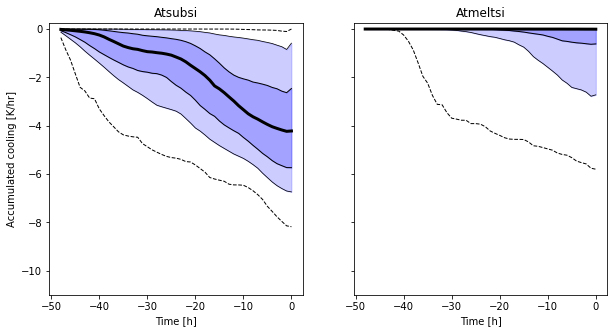

In [39]:
bcp_mean = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].mean().reset_index()
bcp_median = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].median().reset_index()

bcp_q25 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.25).reset_index()
bcp_q75 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.75).reset_index()

bcp_q10 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.10).reset_index()
bcp_q90 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.90).reset_index()

bcp_q1 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.01).reset_index()
bcp_q99 = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.99).reset_index()

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

bc_process = 'Atsubsi'
ax[0].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=1, linestyle='--')
ax[0].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=1, linestyle='--')
ax[0].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[0].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[0].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[0].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[0].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[0].set_title(bc_process)

ax[0].set_ylabel('Accumulated cooling [K/hr]')
ax[0].set_xlabel('Time [h]')

bc_process = 'Atmeltsi'
ax[1].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=1, linestyle='--')
ax[1].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=1, linestyle='--')
ax[1].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[1].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[1].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[1].set_title(bc_process)

ax[1].set_xlabel('Time [h]')

ax[0].set_ylim(-11,0.25)

Text(0.5, 0, 'Time [h]')

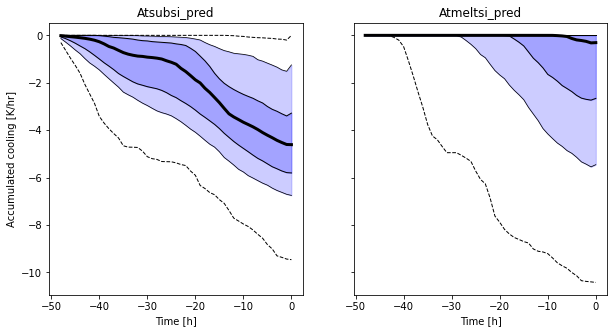

In [40]:
bcp_mean = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].mean().reset_index()
bcp_median = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].median().reset_index()

bcp_q25 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.25).reset_index()
bcp_q75 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.75).reset_index()

bcp_q10 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.10).reset_index()
bcp_q90 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.90).reset_index()

bcp_q1 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.01).reset_index()
bcp_q99 = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.99).reset_index()


fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

bc_process = 'Atsubsi_pred'
ax[0].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=1, linestyle='--')
ax[0].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=1, linestyle='--')
ax[0].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[0].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[0].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[0].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[0].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[0].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[0].set_title(bc_process)

ax[0].set_ylabel('Accumulated cooling [K/hr]')
ax[0].set_xlabel('Time [h]')

bc_process = 'Atmeltsi_pred'
ax[1].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=1, linestyle='--')
ax[1].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=1, linestyle='--')
ax[1].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[1].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[1].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)

ax[1].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[1].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)

ax[1].set_title(bc_process)

ax[1].set_xlabel('Time [h]')



---

In [41]:
bcp_mean   = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].mean().reset_index()
bcp_median = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].median().reset_index()
bcp_q25    = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.25).reset_index()
bcp_q75    = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.75).reset_index()
bcp_q10    = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.10).reset_index()
bcp_q90    = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.90).reset_index()
bcp_q1     = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.01).reset_index()
bcp_q99    = df_traj.groupby(['time'])[['Atsubsi', 'Atmeltsi', 'Atevr']].quantile(0.99).reset_index()


bcp_mean_pred   = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].mean().reset_index()
bcp_median_pred = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].median().reset_index()
bcp_q25_pred    = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.25).reset_index()
bcp_q75_pred    = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.75).reset_index()
bcp_q10_pred    = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.10).reset_index()
bcp_q90_pred    = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.90).reset_index()
bcp_q1_pred     = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.01).reset_index()
bcp_q99_pred    = df_traj_rf.groupby(['time'])[['Atsubsi_pred', 'Atmeltsi_pred']].quantile(0.99).reset_index()


In [42]:
def get_residual(y_true, y_pred):
    return (y_true - y_pred)

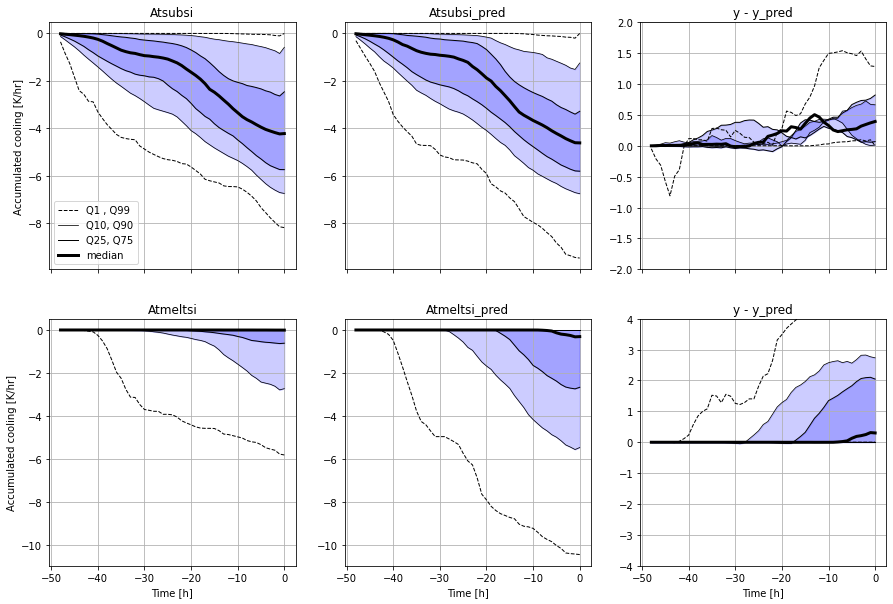

In [43]:
fig,ax = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=False)

# Share y-axis for first two plots in each row
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[1,0].get_shared_y_axes().join(ax[1,0], ax[1,1])

bc_process = 'Atsubsi'
ax[0,0].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , label='Q1 , Q99', linewidth=1, linestyle='--')
ax[0,0].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' ,                   linewidth=1, linestyle='--')
ax[0,0].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , label='Q10, Q90', linewidth=0.75)
ax[0,0].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' ,                   linewidth=0.75)
ax[0,0].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , label='Q25, Q75', linewidth=1)
ax[0,0].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' ,                   linewidth=1)
ax[0,0].plot(bcp_median['time'], bcp_median[bc_process], c='k' , label='median',   linewidth=3)
ax[0,0].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[0,0].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)
ax[0,0].set_title(bc_process)
ax[0,0].set_ylabel('Accumulated cooling [K/hr]')


ax[0,0].legend()

bc_process_pred = 'Atsubsi_pred'
ax[0,1].plot( bcp_q1_pred['time']    , bcp_q1_pred[bc_process_pred]   , c='k' , linewidth=1, linestyle='--')
ax[0,1].plot(bcp_q99_pred['time']   , bcp_q99_pred[bc_process_pred]   , c='k' , linewidth=1, linestyle='--')
ax[0,1].plot(bcp_q10_pred['time']   , bcp_q10_pred[bc_process_pred]   , c='k' , linewidth=0.75)
ax[0,1].plot(bcp_q90_pred['time']   , bcp_q90_pred[bc_process_pred]   , c='k' , linewidth=0.75)
ax[0,1].plot(bcp_q25_pred['time']   , bcp_q25_pred[bc_process_pred]   , c='k' , linewidth=1)
ax[0,1].plot(bcp_q75_pred['time']   , bcp_q75_pred[bc_process_pred]   , c='k' , linewidth=1)
ax[0,1].plot(bcp_median_pred['time'], bcp_median_pred[bc_process_pred], c='k' , linewidth=3)

ax[0,1].fill_between(bcp_q10_pred['time'], bcp_q10_pred[bc_process_pred], bcp_q90_pred[bc_process_pred], color='blue', alpha=0.2)
ax[0,1].fill_between(bcp_q25_pred['time'], bcp_q25_pred[bc_process_pred], bcp_q75_pred[bc_process_pred], color='blue', alpha=0.2)

ax[0,1].set_title(bc_process_pred)



ax[0,2].plot( bcp_q1_pred['time']    ,get_residual(bcp_q1[bc_process]    ,  bcp_q1_pred[bc_process_pred]   )  , c='k' , linewidth=1, linestyle='--')
ax[0,2].plot(bcp_q99_pred['time']   , get_residual(bcp_q99[bc_process]   , bcp_q99_pred[bc_process_pred]   )  , c='k' , linewidth=1, linestyle='--')
ax[0,2].plot(bcp_q10_pred['time']   , get_residual(bcp_q10[bc_process]   , bcp_q10_pred[bc_process_pred]   )  , c='k' , linewidth=0.75)
ax[0,2].plot(bcp_q90_pred['time']   , get_residual(bcp_q90[bc_process]   , bcp_q90_pred[bc_process_pred]   )  , c='k' , linewidth=0.75)
ax[0,2].plot(bcp_q25_pred['time']   , get_residual(bcp_q25[bc_process]   , bcp_q25_pred[bc_process_pred]   )  , c='k' , linewidth=1)
ax[0,2].plot(bcp_q75_pred['time']   , get_residual(bcp_q75[bc_process]   , bcp_q75_pred[bc_process_pred]   )  , c='k' , linewidth=1)
ax[0,2].plot(bcp_median_pred['time'], get_residual(bcp_median[bc_process], bcp_median_pred[bc_process_pred])  , c='k' , linewidth=3)

ax[0,2].fill_between(bcp_q10_pred['time'], get_residual(bcp_q10[bc_process], bcp_q10_pred[bc_process_pred] ), get_residual(bcp_q90[bc_process] , bcp_q90_pred[bc_process_pred] ), color='blue', alpha=0.2)
ax[0,2].fill_between(bcp_q25_pred['time'], get_residual(bcp_q25[bc_process], bcp_q25_pred[bc_process_pred] ), get_residual(bcp_q75[bc_process] , bcp_q75_pred[bc_process_pred] ), color='blue', alpha=0.2)
ax[0,2].set_title('y - y_pred')


ax[0,2].set_ylim(-2, 2)




bc_process = 'Atmeltsi'
ax[1,0].plot(bcp_q1['time']    , bcp_q1[bc_process]    , c='k' , linewidth=1, linestyle='--')
ax[1,0].plot(bcp_q99['time']   , bcp_q99[bc_process]   , c='k' , linewidth=1, linestyle='--')
ax[1,0].plot(bcp_q10['time']   , bcp_q10[bc_process]   , c='k' , linewidth=0.75)
ax[1,0].plot(bcp_q90['time']   , bcp_q90[bc_process]   , c='k' , linewidth=0.75)
ax[1,0].plot(bcp_q25['time']   , bcp_q25[bc_process]   , c='k' , linewidth=1)
ax[1,0].plot(bcp_q75['time']   , bcp_q75[bc_process]   , c='k' , linewidth=1)
ax[1,0].plot(bcp_median['time'], bcp_median[bc_process], c='k' , linewidth=3)
ax[1,0].fill_between(bcp_q10['time'], bcp_q10[bc_process], bcp_q90[bc_process], color='blue', alpha=0.2)
ax[1,0].fill_between(bcp_q25['time'], bcp_q25[bc_process], bcp_q75[bc_process], color='blue', alpha=0.2)
ax[1,0].set_title(bc_process)
ax[1,0].set_ylabel('Accumulated cooling [K/hr]')
ax[1,0].set_xlabel('Time [h]')


bc_process_pred = 'Atmeltsi_pred'
ax[1,1].plot( bcp_q1_pred['time']    , bcp_q1_pred[bc_process_pred]   , c='k' , linewidth=1, linestyle='--')
ax[1,1].plot(bcp_q99_pred['time']   , bcp_q99_pred[bc_process_pred]   , c='k' , linewidth=1, linestyle='--')
ax[1,1].plot(bcp_q10_pred['time']   , bcp_q10_pred[bc_process_pred]   , c='k' , linewidth=0.75)
ax[1,1].plot(bcp_q90_pred['time']   , bcp_q90_pred[bc_process_pred]   , c='k' , linewidth=0.75)
ax[1,1].plot(bcp_q25_pred['time']   , bcp_q25_pred[bc_process_pred]   , c='k' , linewidth=1)
ax[1,1].plot(bcp_q75_pred['time']   , bcp_q75_pred[bc_process_pred]   , c='k' , linewidth=1)
ax[1,1].plot(bcp_median_pred['time'], bcp_median_pred[bc_process_pred], c='k' , linewidth=3)
ax[1,1].fill_between(bcp_q10_pred['time'], bcp_q10_pred[bc_process_pred], bcp_q90_pred[bc_process_pred], color='blue', alpha=0.2)
ax[1,1].fill_between(bcp_q25_pred['time'], bcp_q25_pred[bc_process_pred], bcp_q75_pred[bc_process_pred], color='blue', alpha=0.2)
ax[1,1].set_title(bc_process_pred)
ax[1,1].set_xlabel('Time [h]')



ax[1,2].plot( bcp_q1_pred['time']    ,get_residual(bcp_q1[bc_process]    ,  bcp_q1_pred[bc_process_pred]   )  , c='k' , linewidth=1, linestyle='--')
ax[1,2].plot(bcp_q99_pred['time']   , get_residual(bcp_q99[bc_process]   , bcp_q99_pred[bc_process_pred]   )  , c='k' , linewidth=1, linestyle='--')
ax[1,2].plot(bcp_q10_pred['time']   , get_residual(bcp_q10[bc_process]   , bcp_q10_pred[bc_process_pred]   )  , c='k' , linewidth=0.75)
ax[1,2].plot(bcp_q90_pred['time']   , get_residual(bcp_q90[bc_process]   , bcp_q90_pred[bc_process_pred]   )  , c='k' , linewidth=0.75)
ax[1,2].plot(bcp_q25_pred['time']   , get_residual(bcp_q25[bc_process]   , bcp_q25_pred[bc_process_pred]   )  , c='k' , linewidth=1)
ax[1,2].plot(bcp_q75_pred['time']   , get_residual(bcp_q75[bc_process]   , bcp_q75_pred[bc_process_pred]   )  , c='k' , linewidth=1)
ax[1,2].plot(bcp_median_pred['time'], get_residual(bcp_median[bc_process], bcp_median_pred[bc_process_pred])  , c='k' , linewidth=3)

ax[1,2].fill_between(bcp_q10_pred['time'], get_residual(bcp_q10[bc_process], bcp_q10_pred[bc_process_pred] ), get_residual(bcp_q90[bc_process] , bcp_q90_pred[bc_process_pred] ), color='blue', alpha=0.2)
ax[1,2].fill_between(bcp_q25_pred['time'], get_residual(bcp_q25[bc_process], bcp_q25_pred[bc_process_pred] ), get_residual(bcp_q75[bc_process] , bcp_q75_pred[bc_process_pred] ), color='blue', alpha=0.2)
ax[1,2].set_title('y - y_pred')
ax[1,2].set_xlabel('Time [h]')


ax[1,2].set_ylim(-4, 4)



for i in range(2):
    for j in range(3):
        ax[i,j].grid()


In [44]:
## Plot maps where most cooling happens in cyclone
df_center = df_traj[df_traj['time']==0]
df_center_rf = df_traj_rf[df_traj_rf['time']==0]

In [45]:
df_2dcenter = df_center.groupby(['lon', 'lat'])[['Atsubsi', 'Atmeltsi']].mean().reset_index()
df_2dcenter_pred = df_center_rf.groupby(['lon', 'lat'])[['Atsubsi_pred', 'Atmeltsi_pred']].mean().reset_index()

In [46]:
df_2dcenter

,lon,lat,Atsubsi,Atmeltsi
0,160.8,46.4,-4.940773,-0.312182
1,160.8,46.8,-4.743455,-0.505636
2,160.8,47.2,-4.684091,-0.854773
3,160.8,47.6,-4.634364,-0.900455
4,161.2,46.0,-4.848818,-0.412909
...,...,...,...,...
90,165.2,48.0,-3.352500,-0.039500
91,165.6,46.4,-3.435773,-0.023455
92,165.6,46.8,-3.309000,-0.013190
93,165.6,47.2,-3.445182,-0.015955


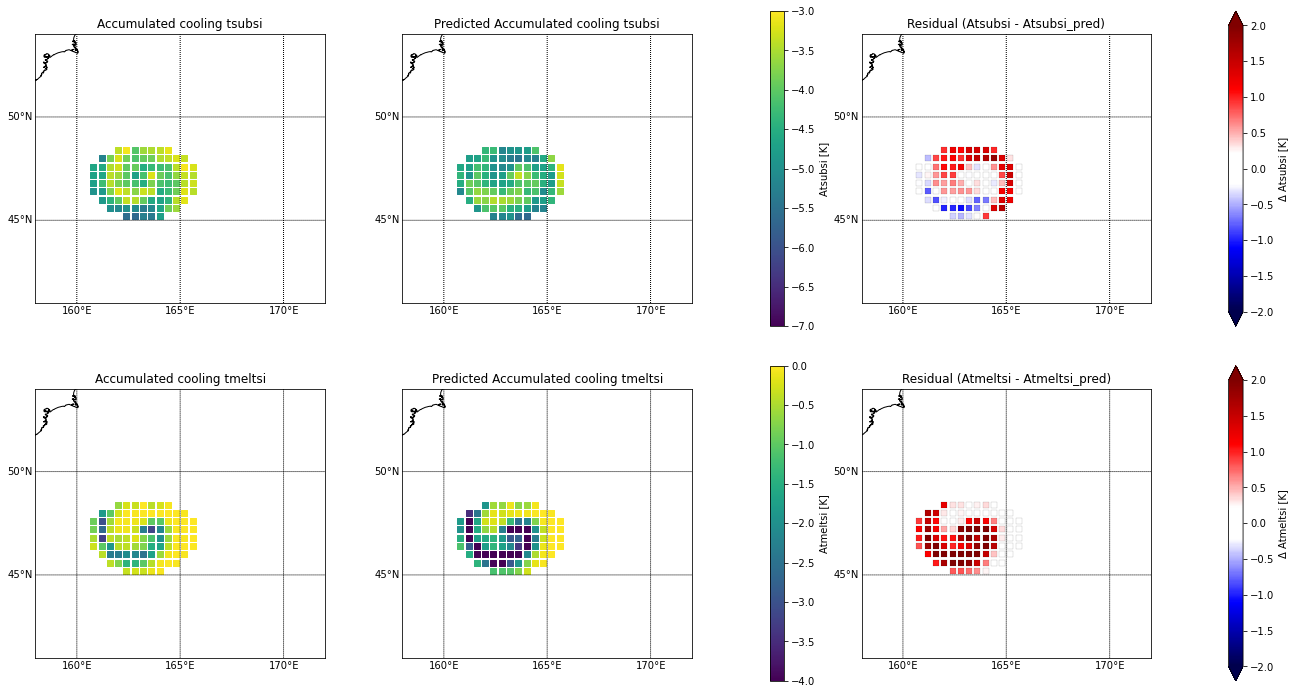

In [83]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors


#==========================================================================================================================
# Define the colors for our new colormap
#---------------------------------------
# Define widht of white space
white_fraction = 1/8
#---------------------------------------

c_frac = int(1/white_fraction)
c_len = int(100*c_frac)
c_mid = int(100*c_frac / 2)


cmap_seismic = plt.cm.get_cmap('seismic')                                                                               
# Define the colors for our new colormap                                                                                
colors = [(cmap_seismic(i/c_len)) for i in range(c_mid)] + [(1,1,1,1)]*100 + [(cmap_seismic(i/c_len)) for i in range(c_mid, c_len)]
cmap_residual = mcolors.LinearSegmentedColormap.from_list("new_PRGn", colors)     
#==========================================================================================================================



# Create a gridspec to handle layout
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 0.05, 1, 0.05])

# Create a figure
fig = plt.figure(figsize=(18, 10))  # Increase figure size to accommodate the additional plots

# Define data sets and variable names
data_sets = [[df_2dcenter, df_2dcenter_pred], [df_2dcenter, df_2dcenter_pred]]
var_names = [['Atsubsi', 'Atsubsi_pred'], ['Atmeltsi', 'Atmeltsi_pred']]
titles = [['Accumulated cooling tsubsi', 'Predicted Accumulated cooling tsubsi'],
          ['Accumulated cooling tmeltsi', 'Predicted Accumulated cooling tmeltsi']]
colorbar_labels = ['Atsubsi', 'Atmeltsi']


vmins = [[-7,-7],[-4,-4]]
vmaxs = [[-3,-3],[0,0]]

# Add titles and colorbar labels for the difference plots
diff_titles = ['Residual (Atsubsi - Atsubsi_pred)', 'Residual (Atmeltsi - Atmeltsi_pred)']
colorbar_diff_labels = ['Δ Atsubsi', 'Δ Atmeltsi']

for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])  # create subplot using gridspec
        data = data_sets[i][j]
        var = var_names[i][j]

        m = Basemap(projection='cyl', resolution='h',
                    llcrnrlat=41, urcrnrlat=54,
                    llcrnrlon=158, urcrnrlon=172, ax=ax)

        ax.grid(True, alpha=0.5)  # Add grid
        m.drawcoastlines()
        m.drawcountries()
        m.drawparallels(np.arange(-90., 91., 5.), labels=[True, False, False, False],
                        ax=ax)  # Draw parallels (latitude lines) for values (in degrees).
        m.drawmeridians(np.arange(-180., 181., 5.), labels=[False, False, False, True],
                        ax=ax)  # Draw meridians (longitude lines) for values (in degrees).

        ax.set_title(titles[i][j])

        x, y = m(data['lon'].values, data['lat'].values)  # use scatter data directly
        sc = ax.scatter(x, y, c=data[var], cmap='viridis', marker='s', vmin=vmins[i][j], vmax=vmaxs[i][j])


    # Add colorbar for each row
    cax = plt.subplot(gs[i, 2])
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
    cbar.set_label(f'{colorbar_labels[i]} [K]')





    # Add difference plot in 4th column
    ax_diff = plt.subplot(gs[i, 3])
    diff = data_sets[i][0][var_names[i][0]] - data_sets[i][1][var_names[i][1]]
    
    m = Basemap(projection='cyl', resolution='h',
                llcrnrlat=41, urcrnrlat=54,
                llcrnrlon=158, urcrnrlon=172, ax=ax_diff)

    ax_diff.grid(True, alpha=0.5)  # Add grid
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90., 91., 5.), labels=[True, False, False, False],
                    ax=ax_diff)  # Draw parallels (latitude lines) for values (in degrees).
    m.drawmeridians(np.arange(-180., 181., 5.), labels=[False, False, False, True],
                    ax=ax_diff)  # Draw meridians (longitude lines) for values (in degrees).

    ax_diff.set_title(diff_titles[i])

    x, y = m(data['lon'].values, data['lat'].values)  # use scatter data directly
    # sc_diff = ax_diff.scatter(x, y, c=diff, cmap=cmap_residual, marker='s', vmin=-2, vmax=2)  # Adjust vmin and vmax as needed
    sc_diff = ax_diff.scatter(x, y, c=diff, cmap=cmap_residual, marker='s', vmin=-2, vmax=2, edgecolors='k', linewidths=0.1)  # Adjust vmin and vmax as needed

    # Add colorbar for difference plot
    cax_diff = plt.subplot(gs[i, 4])
    cbar_diff = fig.colorbar(sc_diff, cax=cax_diff, orientation='vertical', extend='both')
    cbar_diff.set_label(f'{colorbar_diff_labels[i]} [K]')

plt.tight_layout()
plt.show()


---
#### Analysis of predictions

In [48]:
## Get flattened dataframe with all features and class-labels
thresholds  = {'weak': -0.075, 'medium': -0.75}


tsubsi_pred_class = rf_functions.get_y_true(df_traj_rf['tsubsi_pred'], thresholds=thresholds)
tsubsi_class = rf_functions.get_y_true(df_traj['tsubsi'], thresholds=thresholds)

tmeltsi_pred_class = rf_functions.get_y_true(df_traj_rf['tmeltsi_pred'], thresholds=thresholds)
tmeltsi_class = rf_functions.get_y_true(df_traj['tmeltsi'], thresholds=thresholds)

In [49]:
print('Tsubsi predictions:')
tsubsi_conf_mat = rf_functions.get_confmat_clasreport(tsubsi_class, tsubsi_pred_class)
print('\nTmeltsi predictions:')
tsubsi_conf_mat = rf_functions.get_confmat_clasreport(tmeltsi_class, tmeltsi_pred_class)

Tsubsi predictions:
============================    ============================
Confusion matrix:
[[59321  7588    22]
 [ 6544 23887  1330]
 [    4    71   136]]

	------------------------------------------------------------
Classification Report:


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     66931
         1.0       0.76      0.75      0.75     31761
         2.0       0.09      0.64      0.16       211

    accuracy                           0.84     98903
   macro avg       0.58      0.76      0.60     98903
weighted avg       0.85      0.84      0.85     98903


Tmeltsi predictions:
============================    ============================
Confusion matrix:
[[90205  3704    29]
 [  724  3331   840]
 [    0     9    61]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     93938
         1.0       0.47      0.68      0.56      4895
         2.0       0.07      0.87      0.12        70

    accuracy                           0.95     98903
   macro avg       0.51      0.84      0.55     98903
weighted avg       0.97      0.95      0.9